In [1]:
# Import required libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

! conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



## 1. Download and transform data for Russian cities and Russian communities in the USA

In [3]:
input_df = pd.read_csv('input1.csv', header = None)

In [4]:
input_df.columns = ['Area', 'address', 'Latitude', 'Longitude','Status']
input_df

,Area,address,Latitude,Longitude,Status
0,Moscow,"'Malyy Patriarshiy, Moscow, Russia'",NaN,NaN,o
1,SPb,NaN,59.933090,30.334865,o
2,Yekaterinburg,"Lenina 44, Yekaterinburg, Russia",NaN,NaN,o
3,Novosibirsk,NaN,55.031845,82.917733,o
4,Miami,"Sunny Isles Beach, Miami, FL",NaN,NaN,us
5,San Francisco,"Geary Boulevard, San Francisco, CA",NaN,NaN,us
6,Los Angeles,"Santa Monica Boulevard, Los Angeles, CA",NaN,NaN,us
7,Denver,"Glendale, Denver, CO",NaN,NaN,us
8,Cleveland,"Euclid, Cleveland, OH",NaN,NaN,us


In [4]:
input_df.shape

(9, 5)

In [7]:
# get coordinates
for i in range(input_df.shape[0]):
    address = input_df.iloc[i]['address']
    if  pd.notnull(address):
        print(address)
        geolocator = Nominatim(user_agent="can_explorer")
        location = geolocator.geocode(address)
        input_df.iloc[i,2] = location.latitude
        input_df.iloc[i,3] = location.longitude
        
input_df

'Malyy Patriarshiy, Moscow, Russia'
Lenina 44, Yekaterinburg, Russia
Sunny Isles Beach, Miami, FL
Geary Boulevard, San Francisco, CA
Santa Monica Boulevard, Los Angeles, CA
Glendale, Denver, CO
Euclid, Cleveland, OH


,Area,address,Latitude,Longitude,Status
0,Moscow,"'Malyy Patriarshiy, Moscow, Russia'",55.763532,37.591192,o
1,SPb,NaN,59.933090,30.334865,o
2,Yekaterinburg,"Lenina 44, Yekaterinburg, Russia",56.836138,60.583289,o
3,Novosibirsk,NaN,55.031845,82.917733,o
4,Miami,"Sunny Isles Beach, Miami, FL",25.939003,-80.125534,us
5,San Francisco,"Geary Boulevard, San Francisco, CA",37.784619,-122.431422,us
6,Los Angeles,"Santa Monica Boulevard, Los Angeles, CA",34.015590,-118.496198,us
7,Denver,"Glendale, Denver, CO",39.739236,-104.984862,us
8,Cleveland,"Euclid, Cleveland, OH",41.577056,-81.550564,us


In [8]:
# drop column 'address'
input_df.drop(['address'], axis = 1, inplace = True)
input_df

,Area,Latitude,Longitude,Status
0,Moscow,55.763532,37.591192,o
1,SPb,59.933090,30.334865,o
2,Yekaterinburg,56.836138,60.583289,o
3,Novosibirsk,55.031845,82.917733,o
4,Miami,25.939003,-80.125534,us
5,San Francisco,37.784619,-122.431422,us
6,Los Angeles,34.015590,-118.496198,us
7,Denver,39.739236,-104.984862,us
8,Cleveland,41.577056,-81.550564,us


In [9]:
# create dictionary to identify Country from a name of an area
status_dict = {}
for i in range(input_df.shape[0]):status_dict[input_df.iloc[i,0]]=input_df.iloc[i,3]


In [10]:
status_dict

{'Cleveland': 'us',
 'Denver': 'us',
 'Los Angeles': 'us',
 'Miami': 'us',
 'Moscow': 'o',
 'Novosibirsk': 'o',
 'SPb': 'o',
 'San Francisco': 'us',
 'Yekaterinburg': 'o'}

## Acquisition of venues for areas from Foursquare

In [20]:
CLIENT_ID = 'G1QYWBPLQJ2BJKYRNWAXU3QTLZAFOUW3VZO15OLXQ3IZHRBS' 
CLIENT_SECRET = 'NLWMY0GFVIUR1I3KUS2L41RE2DKRCSNC3R4JVCMAFPPUSP4P' 
VERSION = '20180604'

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: G1QYWBPLQJ2BJKYRNWAXU3QTLZAFOUW3VZO15OLXQ3IZHRBS
CLIENT_SECRET:NLWMY0GFVIUR1I3KUS2L41RE2DKRCSNC3R4JVCMAFPPUSP4P


In [21]:
def getNearbyVenues(names, status, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, st, lat, lng in zip(names,status, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            st,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 'Status',
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
LIMIT = 100 #set maximum amount of venues around
input_venues = getNearbyVenues(names=input_df['Area'], status = input_df['Status'],
                                   latitudes=input_df['Latitude'],
                                   longitudes=input_df['Longitude']
                                  )

In [12]:
input_venues.head()

,Area,Status,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Moscow,o,55.763532,37.591192,Patriarshiye Ponds (Патриаршие пруды),55.763827,37.592141,Park
1,Moscow,o,55.763532,37.591192,Neгодники,55.762319,37.591709,Restaurant
2,Moscow,o,55.763532,37.591192,The Clu Office,55.763023,37.593614,Electronics Store
3,Moscow,o,55.763532,37.591192,I Love Cake,55.762578,37.592007,Cupcake Shop
4,Moscow,o,55.763532,37.591192,Tigerbunny,55.762801,37.592361,Frozen Yogurt Shop


## Explore data for different kind of points

In [30]:
to_explore = input_venues[input_venues['Status']=='us']

In [21]:
to_explore.shape

(296, 8)

In [31]:
to_explore.head(5)

,Area,Status,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
333,Miami,us,25.939003,-80.125534,Winston Towers,25.936950,-80.126892,Building
334,Miami,us,25.939003,-80.125534,Walgreens,25.938154,-80.121895,Pharmacy
335,Miami,us,25.939003,-80.125534,Juice & Java,25.939320,-80.121624,Vegetarian / Vegan Restaurant
336,Miami,us,25.939003,-80.125534,El Mega Chuzo,25.939563,-80.121767,Latin American Restaurant
337,Miami,us,25.939003,-80.125534,Sumo Sushi,25.939537,-80.121898,Sushi Restaurant


In [13]:
print(sorted(list(input_venues['Venue Category'].unique())))

['ATM', 'Adult Boutique', 'American Restaurant', 'Aquarium', 'Arcade', 'Arepa Restaurant', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant', 'Australian Restaurant', 'BBQ Joint', 'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Basketball Court', 'Bath House', 'Beach', 'Bed & Breakfast', 'Beer Bar', 'Board Shop', 'Bookstore', 'Boutique', 'Breakfast Spot', 'Bridal Shop', 'Bubble Tea Shop', 'Buffet', 'Building', 'Burger Joint', 'Bus Stop', 'Café', 'Camera Store', 'Candy Store', 'Caucasian Restaurant', 'Chinese Restaurant', 'Clothing Store', 'Cocktail Bar', 'Coffee Shop', 'Comedy Club', 'Comfort Food Restaurant', 'Concert Hall', 'Convenience Store', 'Cosmetics Shop', 'Creperie', 'Cultural Center', 'Cupcake Shop', 'Dance Studio', 'Deli / Bodega', 'Dessert Shop', 'Diner', 'Discount Store', 'Dive Bar', 'Donut Shop', 'Eastern European Restaurant', 'Electronics Store', 'Exhibit', 'Farmers Market', 'Fast Food Restaurant', 'Flower Shop', 'Food & Drink Shop', 'Food Truck', 'French Re

## Get data on ammount of ventures for evry area

In [19]:
input_venues.groupby('Area').count()['Venue Category'].transpose

<bound method IndexOpsMixin.transpose of Area
Cleveland          9
Denver            67
Los Angeles      100
Miami             20
Moscow            84
Novosibirsk      100
SPb               97
San Francisco    100
Yekaterinburg     52
Name: Venue Category, dtype: int64>

In [14]:
len(list(input_venues['Venue Category'].unique()))

184

In [18]:
input_venues.shape

(629, 8)

In [24]:
len(list(to_explore['Venue Category'].unique()))

118

In [91]:
# back-up, just in case
input_venues.to_csv('input_venues.csv')

In [11]:
#input_venues=pd.read_csv('input_venues.csv', index_col= 0)

## Download other data, cleaning and unication

In [99]:
# download data on venues in Toronto neighborhoods from Assignment week 3
toronto_venues = pd.read_csv('toronto_venue.csv', index_col= 0)

In [26]:
# download data on venues in NY neighborhoods from Lab week 3
ny_venues = pd.read_csv('ny_venue.csv', index_col=0)

In [107]:
toronto_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [113]:
toronto_venues.shape

(2201, 7)

### clean data: drop areas with amount of venues less than 3

In [114]:
torontom = pd.DataFrame(toronto_venues.groupby('Neighborhood').count()['Venue Category'])

In [115]:
torontom = torontom[torontom['Venue Category']<3]

In [116]:
torontom = set(torontom.index)
torontom

set()

In [117]:
for i in torontom:
    toronto_venues.replace(i, np.nan, inplace=True)



In [112]:
toronto_venues.dropna(axis=0, inplace = True)

In [ ]:
toronto_venues.shape

In [119]:
len(list(toronto_venues['Venue Category'].unique()))

265

In [28]:
ny_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy
4,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station


In [120]:
ny_venues.shape

(10258, 7)

In [121]:
nym = pd.DataFrame(ny_venues.groupby('Neighborhood').count()['Venue Category'])

In [122]:
nym = nym[nym['Venue Category']<3]
nym = set(nym.index)
for i in nym:
    ny_venues.replace(i, np.nan, inplace=True)
    
ny_venues.dropna(axis=0, inplace = True)

In [124]:
ny_venues.shape

(10248, 7)

In [126]:
len(list(ny_venues['Venue Category'].unique()))

430

### Unification of data

In [26]:
input_venues.head(2)

,Area,Status,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Moscow,o,55.763532,37.591192,Patriarshiye Ponds (Патриаршие пруды),55.763827,37.592141,Park
1,Moscow,o,55.763532,37.591192,Neгодники,55.762319,37.591709,Restaurant


In [127]:
toronto_venues['Status']='can'


In [128]:
ny_venues['Status'] = 'us'

In [129]:
ny_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Status
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,us
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,us
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,us
3,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy,us
4,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station,us


In [130]:
col_names = list(ny_venues.columns)
col_names = [col_names[0]] + [col_names[-1]] + col_names[1:-1]

In [131]:
ny_venues_i = ny_venues[col_names]
toronto_venues_i = toronto_venues[col_names]

In [132]:
ny_venues_i.head(3)

,Neighborhood,Status,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,us,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,us,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,us,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop


In [133]:
toronto_venues_i.head(3)

,Neighborhood,Status,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Victoria Village,can,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,can,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,can,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [134]:
col_names = list(input_venues.columns)
ny_venues_i.columns = col_names
toronto_venues_i.columns = col_names

In [135]:
toronto_venues_i.head(3)

,Area,Status,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Victoria Village,can,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,can,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,can,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


### Merge data in one table

In [136]:
merge_venues = pd.concat([ny_venues_i, toronto_venues_i, input_venues])
print(ny_venues_i.shape, toronto_venues_i.shape, input_venues.shape, merge_venues.shape)

(10248, 8) (2201, 8) (629, 8) (13078, 8)


In [137]:
merge_venues.reset_index(drop = True, inplace = True)
merge_venues.head(5)

,Area,Status,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,us,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,us,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,us,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,us,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy
4,Wakefield,us,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station


In [471]:
len(list(merge_venues['Venue Category'].unique()))

468

In [138]:
# back-up
merge_venues.to_csv('merge_venues.csv')

In [ ]:
#merge_venues=pd.read_csv('merge_venues.csv', index_col= 0)

## Update dictionary on Country/Area

In [157]:
for i in set(ny_venues_i['Area']):status_dict[i]='us'

In [158]:
for i in set(toronto_venues_i['Area']):status_dict[i]='can'

## Encoding

In [159]:
# one hot encoding
merge_onehot = pd.get_dummies(merge_venues[['Venue Category']], prefix="", prefix_sep="")


col = list(merge_onehot.columns) # names of columns
# add Area column back to dataframe
merge_onehot['Area'] = merge_venues['Area'] 



# put Area column to the first column
fixed_columns = ['Area'] + col
merge_onehot = merge_onehot[fixed_columns]

merge_onehot.head(10)

,Area,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Re

In [160]:
len(merge_onehot['Area'].unique())

386

In [161]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [214]:
# group by Areas and transform Features to frequency
merge_grouped = merge_onehot.groupby('Area').mean().reset_index()
merge_grouped.head(10)

,Area,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Re

In [216]:
merge_grouped.shape

(386, 469)

## Let's explore frequency of venue categories

In [472]:
categories = merge_venues['Venue Category']
from collections import Counter
cat_ven = Counter(categories)

In [501]:
cat_venr = []
for i in cat_ven:
    cat_venr.append([cat_ven[i], i])
    
df_cat=pd.DataFrame(sorted(cat_venr, reverse = True))
df_cat.columns = ['Count', 'Venue Cagegory']
df_cat['Frequency * 100'] = df_cat['Count']/sum(df_cat['Count'])
df_cat=df_cat[['Venue Cagegory','Count','Frequency * 100']]
df_cat.head(10)

,Venue Cagegory,Count,Frequency * 100
0,Pizza Place,509,0.038920
1,Coffee Shop,507,0.038767
2,Italian Restaurant,364,0.027833
3,Bakery,290,0.022175
4,Deli / Bodega,283,0.021639
5,Café,280,0.021410
6,Bar,280,0.021410
7,Sandwich Place,231,0.017663
8,Chinese Restaurant,229,0.017510
9,Park,223,0.017052


## Create a table of the most common venues for areas

In [217]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = merge_grouped['Area']


for ind in np.arange(merge_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(merge_grouped.iloc[ind, :], num_top_venues)

area_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Café,Thai Restaurant,Restaurant,Sushi Restaurant,Seafood Restaurant,Steakhouse,Asian Restaurant,Breakfast Spot
1,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,English Restaurant,Entertainment Service,Factory
3,"Alderwood, Long Branch",Pizza Place,Pub,Pharmacy,Coffee Shop,Sandwich Place,Pool,Skating Rink,Gym,Electronics Store,Empanada Restaurant
4,Allerton,Pizza Place,Bakery,Deli / Bodega,Supermarket,Intersection,Discount Store,Electronics Store,Check Cashing Service,Chinese Restaurant,Donut Shop


In [176]:
# back-up
merge_grouped.to_csv('save_point.csv')

In [38]:
merge_grouped = pd.read_csv('save_point.csv', index_col= 0)

In [218]:
# set number of clusters - with that amount the model sustainably distinguish between two different groups of Russian locations
kclusters = 75

merge_grouped_clustering = merge_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(merge_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([37, 44, 46, 47, 47, 47, 32, 10,  5, 16], dtype=int32)

In [219]:
# add clustering labels
area_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)

area_venues_sorted.head() # check the last columns!

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",37,Coffee Shop,Bar,Café,Thai Restaurant,Restaurant,Sushi Restaurant,Seafood Restaurant,Steakhouse,Asian Restaurant,Breakfast Spot
1,Agincourt,44,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",46,Grocery Store,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,English Restaurant,Entertainment Service,Factory
3,"Alderwood, Long Branch",47,Pizza Place,Pub,Pharmacy,Coffee Shop,Sandwich Place,Pool,Skating Rink,Gym,Electronics Store,Empanada Restaurant
4,Allerton,47,Pizza Place,Bakery,Deli / Bodega,Supermarket,Intersection,Discount Store,Electronics Store,Check Cashing Service,Chinese Restaurant,Donut Shop


In [220]:
# use dictionary to add Country to an Area
country =[]
for i in area_venues_sorted['Area']: country.append(status_dict[i])
status = np.asarray(country)
area_venues_sorted.insert(1, 'Country', status)

area_venues_sorted.head()

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",can,37,Coffee Shop,Bar,Café,Thai Restaurant,Restaurant,Sushi Restaurant,Seafood Restaurant,Steakhouse,Asian Restaurant,Breakfast Spot
1,Agincourt,can,44,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",can,46,Grocery Store,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,English Restaurant,Entertainment Service,Factory
3,"Alderwood, Long Branch",can,47,Pizza Place,Pub,Pharmacy,Coffee Shop,Sandwich Place,Pool,Skating Rink,Gym,Electronics Store,Empanada Restaurant
4,Allerton,us,47,Pizza Place,Bakery,Deli / Bodega,Supermarket,Intersection,Discount Store,Electronics Store,Check Cashing Service,Chinese Restaurant,Donut Shop


## Check clusters for Russian cities

In [221]:
area_venues_sorted[area_venues_sorted['Country']=='o']

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
240,Moscow,o,1,Wine Bar,Caucasian Restaurant,Restaurant,Seafood Restaurant,Italian Restaurant,Bakery,Theater,Coffee Shop,Shoe Store,Café
259,Novosibirsk,o,37,Coffee Shop,Pub,Cocktail Bar,Restaurant,Café,Hookah Bar,Italian Restaurant,Gastropub,Bakery,Plaza
308,SPb,o,1,Theater,Hotel,Concert Hall,Park,Burger Joint,Restaurant,Plaza,Eastern European Restaurant,Hostel,Italian Restaurant
383,Yekaterinburg,o,37,Coffee Shop,Gym / Fitness Center,Spa,Sporting Goods Shop,Hotel,Liquor Store,Fast Food Restaurant,Bookstore,Toy / Game Store,Gym


## Explore clusters with Russian cities

In [223]:
area_venues_sorted.loc[area_venues_sorted['Cluster Labels'] == 1]

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Astoria Heights,us,1,Bakery,Supermarket,Cocktail Bar,Pizza Place,Hostel,Bus Station,Playground,Gourmet Shop,Plaza,Burger Joint
15,Battery Park City,us,1,Park,Coffee Shop,Hotel,Boat or Ferry,Gym,Memorial Site,Women's Store,Shopping Mall,Playground,Italian Restaurant
17,Bay Terrace,us,1,Clothing Store,Supermarket,Donut Shop,Kids Store,Italian Restaurant,Shoe Store,Cosmetics Shop,Lingerie Store,Mobile Phone Shop,Women's Store
36,Boerum Hill,us,1,Dance Studio,Coffee Shop,Bar,Arts & Crafts Store,Sandwich Place,French Restaurant,Furniture / Home Store,Bakery,Yoga Studio,Cosmetics Shop
45,Brooklyn Heights,us,1,Yoga Studio,Deli / Bodega,Italian Restaurant,Park,Bakery,Pizza Place,Gym,Cosmetics Shop,American Restaurant,Mexican Restaurant
49,Business Reply Mail Processing Centre 969 Eastern,can,1,Brewery,Farmers Market,Park,Auto Workshop,Skate Park,Light Rail Station,Smoke Shop,Garden Center,Restaurant,Butcher
59,Carroll Gardens,us,1,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Wine Shop,Gym / Fitness Center,Bakery,Spa,Bar,Thai Restaurant
64,Central Harlem,us,1,Seafood Restaurant,Bar,Cosmetics Shop,African Restaurant,French Restaurant,Chinese Restaurant,Art Gallery,American Restaurant,Public Art,Spa
65,Charleston,us,1,Cosmetics Shop,Big Box Store,Movie Theater,Grocery Store,Donut Shop,Coffee Shop,Hardware Store,Clothing Store,Gym / Fitness Center,Shoe Store
66,Chelsea,us,1,Coffee Shop,Italian Restaurant,Bakery,Theater,American Restaurant,Ice Cream Shop,Hotel,Wine Shop,French Restaurant,Art Gallery


In [224]:
area_venues_sorted.loc[area_venues_sorted['Cluster Labels'] == 37]

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",can,37,Coffee Shop,Bar,Café,Thai Restaurant,Restaurant,Sushi Restaurant,Seafood Restaurant,Steakhouse,Asian Restaurant,Breakfast Spot
14,"Bathurst Manor, Downsview North, Wilson Heights",can,37,Coffee Shop,Chinese Restaurant,Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Supermarket,Sushi Restaurant,Gas Station,Middle Eastern Restaurant,Shopping Mall
22,"Bedford Park, Lawrence Manor East",can,37,Sandwich Place,Italian Restaurant,Coffee Shop,Restaurant,Sushi Restaurant,Greek Restaurant,Pizza Place,Pharmacy,Cupcake Shop,Indian Restaurant
30,Berczy Park,can,37,Coffee Shop,Farmers Market,Cocktail Bar,Café,Bakery,Seafood Restaurant,Beer Bar,Restaurant,Cheese Shop,French Restaurant
35,"Bloordale Gardens, Eringate, Markland Wood, Ol...",can,37,Cosmetics Shop,Pet Store,Pizza Place,Beer Store,Coffee Shop,Café,Liquor Store,Convenience Store,Ethiopian Restaurant,Entertainment Service
43,"Brockton, Exhibition Place, Parkdale Village",can,37,Café,Coffee Shop,Breakfast Spot,Nightclub,Gym / Fitness Center,Gym,Grocery Store,Furniture / Home Store,Burrito Place,Yoga Studio
53,"Cabbagetown, St. James Town",can,37,Coffee Shop,Pub,Market,Pizza Place,Bakery,Chinese Restaurant,Park,Café,Italian Restaurant,Restaurant
58,Carnegie Hill,us,37,Coffee Shop,Pizza Place,Café,Yoga Studio,Cosmetics Shop,Wine Shop,Bookstore,Japanese Restaurant,Bakery,Gym
63,Central Bay Street,can,37,Coffee Shop,Italian Restaurant,Burger Joint,Ice Cream Shop,Japanese Restaurant,Sandwich Place,Thai Restaurant,Salad Place,Café,Bubble Tea Shop
69,Christie,can,37,Grocery Store,Café,Park,Italian Restaurant,Restaurant,Nightclub,Athletics & Sports,Diner,Gas Station,Coffee Shop


In [225]:
area_venues_sorted.loc[area_venues_sorted['Cluster Labels'] == 1].shape[0]

55

In [236]:
area_venues_sorted.to_csv('final.csv')

In [226]:
cl_rate=[]
for i in range(kclusters):
    n = area_venues_sorted.loc[area_venues_sorted['Cluster Labels'] == i].shape[0]
    #print('Cluster {}: {} items'.format(i, n))
    if n>9: cl_rate.append([i,n])

In [227]:
cl_rate

[[0, 11],
 [1, 55],
 [5, 11],
 [7, 13],
 [8, 12],
 [12, 10],
 [15, 50],
 [16, 10],
 [27, 21],
 [37, 41],
 [47, 28],
 [68, 31],
 [74, 10]]

In [191]:
import matplotlib.pyplot as plt
%matplotlib inline

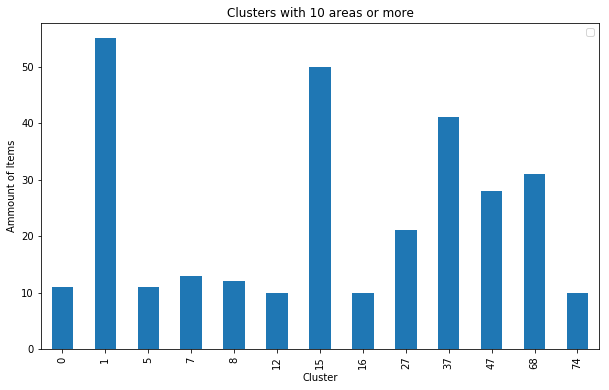

In [469]:
cl=pd.DataFrame(cl_rate)
cl.columns=['Cluster','Items']
cl.set_index('Cluster', inplace = True)
cl.plot(kind='bar', figsize=(10,6))

plt.xlabel('Cluster')
plt.ylabel('Ammount of Items')
plt.legend('')
plt.title('Clusters with 10 areas or more')

plt.show()

In [232]:
cl


,Items
Cluster,
0,11
1,55
5,11
7,13
8,12
12,10
15,50
16,10
27,21


In [265]:
cluster1=area_venues_sorted.loc[area_venues_sorted['Cluster Labels'] == 1]
cluster37=area_venues_sorted.loc[area_venues_sorted['Cluster Labels'] == 37]

In [467]:
per_us=area_venues_sorted[area_venues_sorted['Country']=='us'].shape[0]/area_venues_sorted.shape[0]
per_can=area_venues_sorted[area_venues_sorted['Country']=='can'].shape[0]/area_venues_sorted.shape[0]
per_ru = area_venues_sorted[area_venues_sorted['Country']=='o'].shape[0]/area_venues_sorted.shape[0]

In [468]:
print('In dataset there are {:.2f}% from the USA, {:.2f}% from Canada,\
{:.2f}% from Russia'.format(per_us*100,per_can*100,per_ru*100))

In dataset there are 76.68% from the USA, 22.28% from Canada,1.04% from Russia


## Percentage of the USA areas in cluster with Moscow and Saint Petersburg

In [252]:
cluster1[cluster1['Country']=='us'].shape[0]/(cluster1.shape[0])

0.9454545454545454

In [377]:
col_cl=['Cluster','US','Canada','RU']
df_cl = {'Cluster':['1'],'US':[cluster1[cluster1['Country']=='us'].shape[0]],
         'Canada':[cluster1[cluster1['Country']=='can'].shape[0]],
         'RU':[cluster1[cluster1['Country']=='o'].shape[0]]}

In [378]:
df_cl

{'Canada': [1], 'Cluster': ['1'], 'RU': [2], 'US': [52]}

## Percentage of the USA areas in cluster with Novosibirsk and Yekaterinburg

In [470]:
cluster37[cluster37['Country']=='can'].shape[0]/(cluster37.shape[0])

0.7560975609756098

In [380]:
df_cl['Cluster'].append('37')
df_cl['US'].append(cluster37[cluster37['Country']=='us'].shape[0])
df_cl['Canada'].append(cluster37[cluster37['Country']=='can'].shape[0])
df_cl['RU'].append(cluster1[cluster1['Country']=='o'].shape[0])


in dataset there are 76.68% from the USA, 22.28% from Canada,1.04% from Russia


In [381]:
count_clusters = pd.DataFrame(df_cl, columns=['Cluster','US','Canada','RU'])
count_clusters

,Cluster,US,Canada,RU
0,1,52,1,2
1,37,8,31,2


In [382]:
count_clusters.set_index('Cluster', drop = True, inplace = True)

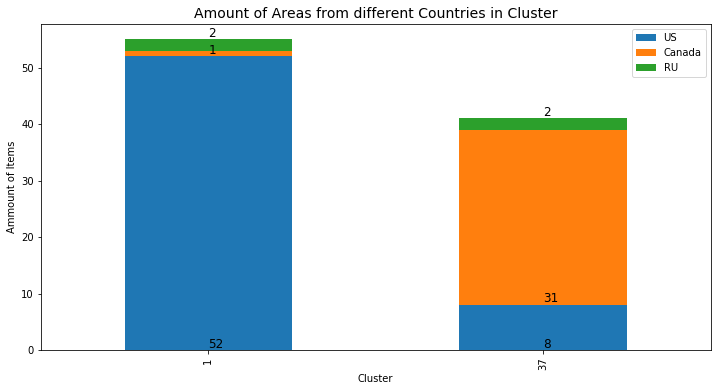

In [450]:

#cl.columns=['Cluster','Items']
#count_clasters.transpose ('Cluster', inplace = True)
count_clusters.plot(kind='bar', figsize=(12,6), stacked = True)

plt.xlabel('Cluster')
plt.ylabel('Ammount of Items')

for i in range(len(count_clusters.iloc[0])-1):
    k=0.5
    for n in range(len(count_clusters.columns)):
        label = count_clusters.iloc[i,n]
        plt.annotate(label, xy=(i, k), color='black', size = 12)
        k=k+label+(n)*2


plt.title('Amount of Areas from different Countries in Cluster', size = 14)

plt.show()

## Explore Areas with known Russian communities

In [233]:
area_venues_sorted.loc[area_venues_sorted['Area'] == 'Brighton Beach']

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Brighton Beach,us,15,Beach,Eastern European Restaurant,Russian Restaurant,Restaurant,Pharmacy,Gourmet Shop,Sushi Restaurant,Mobile Phone Shop,Bank,Neighborhood


## there is no russian restorants in priority in Moscow or SPb

In [248]:
area_venues_sorted.loc[area_venues_sorted['Area'] == 'Denver']

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,Denver,us,16,Sandwich Place,Coffee Shop,Mexican Restaurant,Convenience Store,Pub,Pizza Place,Noodle House,Gym,Exhibit,Yoga Studio


In [502]:
area_venues_sorted.loc[area_venues_sorted['Area'] == 'Los Angeles']

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
214,Los Angeles,us,12,Clothing Store,American Restaurant,Furniture / Home Store,Women's Store,Yoga Studio,Burger Joint,Seafood Restaurant,Coffee Shop,Spa,Mexican Restaurant


In [245]:
area_venues_sorted.loc[area_venues_sorted['Area'] == 'Cleveland']

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
78,Cleveland,us,16,Convenience Store,Irish Pub,New American Restaurant,Wine Shop,Adult Boutique,Pizza Place,Gas Station,Sandwich Place,Event Service,Exhibit


In [247]:
area_venues_sorted.loc[area_venues_sorted['Cluster Labels'] == 15]

,Area,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Auburndale,us,15,Discount Store,Furniture / Home Store,Pharmacy,Miscellaneous Shop,Mobile Phone Shop,Pet Store,Toy / Game Store,Korean Restaurant,Fast Food Restaurant,Hookah Bar
13,Bath Beach,us,15,Chinese Restaurant,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Bubble Tea Shop,Italian Restaurant,Bakery,Food Truck,Restaurant,Halal Restaurant
18,Baychester,us,15,Donut Shop,Music Venue,Arcade,Bank,Gym / Fitness Center,Mattress Store,Men's Store,Sandwich Place,Mexican Restaurant,Pet Store
40,Brighton Beach,us,15,Beach,Eastern European Restaurant,Russian Restaurant,Restaurant,Pharmacy,Gourmet Shop,Sushi Restaurant,Mobile Phone Shop,Bank,Neighborhood
46,Brownsville,us,15,Restaurant,Park,Moving Target,Chinese Restaurant,Pharmacy,Discount Store,Trail,Performing Arts Venue,Spanish Restaurant,Fried Chicken Joint
62,Cedarbrae,can,15,Bakery,Fried Chicken Joint,Bank,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Caribbean Restaurant,Yoga Studio,Event Space
72,City Line,us,15,Donut Shop,Shoe Store,Bus Stop,Grocery Store,Gift Shop,Lingerie Store,Liquor Store,Clothing Store,Sandwich Place,Bank
74,"Clairlea, Golden Mile, Oakridge",can,15,Bus Line,Bakery,Park,Soccer Field,Metro Station,Ice Cream Shop,Bus Station,Yoga Studio,Eye Doctor,Exhibit
75,Claremont Village,us,15,Chinese Restaurant,Grocery Store,Bakery,Restaurant,Park,Gym,Liquor Store,Caribbean Restaurant,Pizza Place,Discount Store
82,Co-op City,us,15,Bus Station,Baseball Field,Discount Store,Restaurant,Pizza Place,Fast Food Restaurant,Supermarket,Pharmacy,Mattress Store,Ice Cream Shop
